In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import lightning as L

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

In [3]:
raw_df = pd.read_csv('NVDA_110721_Final_1_fdr.csv', index_col='Date')
raw_df

,Close,MA5,MA20,MA60,RSI14,std,upperb,lowerb,%K,%D,SP500,NASDAQ_COMP
Date,,,,,,,,,,,,
2011/07/21,3.675000,3.543000,3.782250,4.299750,40.927948,0.196449,4.175147,3.389353,40.601489,26.315786,1343.800049,2834.429932
2011/07/22,3.750000,3.588000,3.767125,4.281833,45.013998,0.185909,4.138942,3.395308,51.879688,36.090216,1345.020020,2858.830078
2011/07/25,3.690000,3.636000,3.754875,4.262042,42.482342,0.182302,4.119478,3.390272,50.000021,47.493733,1337.430054,2842.800049
2011/07/26,3.600000,3.645000,3.742250,4.238708,38.944195,0.183921,4.110092,3.374408,35.294105,45.724605,1331.939941,2839.959961
2011/07/27,3.465000,3.636000,3.721750,4.214250,34.326053,0.191057,4.103864,3.339636,11.999989,32.431371,1304.890015,2764.790039
...,...,...,...,...,...,...,...,...,...,...,...,...
2021/07/14,198.414993,201.113998,196.027248,169.003166,60.429947,8.187827,212.402902,179.651594,47.816155,67.231458,4374.299805,14644.950200
2021/07/15,189.662506,199.241000,196.605248,169.635666,49.087893,7.204900,211.015048,182.195448,5.343416,40.533957,4360.029785,14543.129880
2021/07/16,181.610001,195.462500,196.357124,170.102416,41.390788,7.640857,211.638837,181.075411,3.140631,18.766734,4327.160156,14427.240230


# GPU Setting

In [9]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f"{device} 사용 가능합니다")

mps:0 사용 가능합니다


# Data Visualization

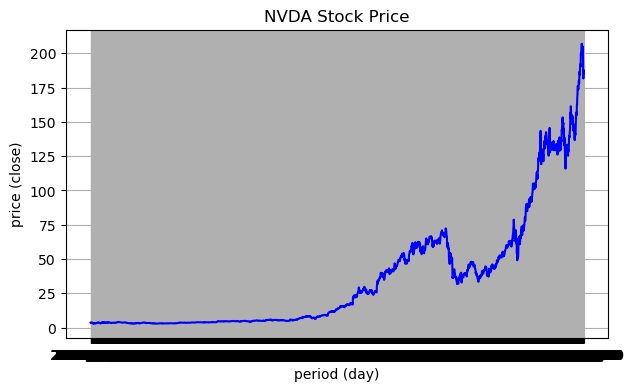

In [4]:
plt.figure(figsize=(7, 4))

plt.title('NVDA Stock Price')
plt.ylabel('price (close)')
plt.xlabel('period (day)')
plt.grid()

plt.plot(raw_df['Close'], label='Close', color='b')

# Normalization 0~1

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler()
scaler_cols = raw_df.columns.tolist()
print(scaler_cols)
 
# 정규화 수행
scaled_df = scaler.fit_transform(raw_df[[scaler_cols[0]]])
print(type(scaled_df))

scaled_df = pd.DataFrame(scaled_df, columns=[scaler_cols[0]])
print(scaled_df)


['Close', 'MA5', 'MA20', 'MA60', 'RSI14', 'std', 'upperb', 'lowerb', '%K', '%D', 'SP500', 'NASDAQ_COMP']
<class 'numpy.ndarray'>
         Close
0     0.004066
1     0.004433
2     0.004139
3     0.003698
4     0.003037
...        ...
2511  0.958019
2512  0.915144
2513  0.875698
2514  0.906008
2515  0.897791

[2516 rows x 1 columns]


In [7]:
feature_cols = [scaler_cols[0]]
label_cols = ['Close']

label_df = pd.DataFrame(scaled_df, columns=label_cols)
feature_df = pd.DataFrame(scaled_df, columns=feature_cols)

print(feature_df)
print(label_df)

         Close
0     0.004066
1     0.004433
2     0.004139
3     0.003698
4     0.003037
...        ...
2511  0.958019
2512  0.915144
2513  0.875698
2514  0.906008
2515  0.897791

[2516 rows x 1 columns]
         Close
0     0.004066
1     0.004433
2     0.004139
3     0.003698
4     0.003037
...        ...
2511  0.958019
2512  0.915144
2513  0.875698
2514  0.906008
2515  0.897791

[2516 rows x 1 columns]


# Torch model

In [8]:
class PricePredictionModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=1)

    def lstm_unit(self, input_value, long_memory, short_memory):
        long_remember_percent = torch.sigmoid((short_memory * self.wlr1) +
                                             (input_value * self.wlr2) +
                                             self.blr1)
        
        potential_remember_percent = torch.sigmoid((short_memory * self.wpr1) +
                                             (input_value * self.wpr2) +
                                             self.bpr1)

        potential_memory = torch.tanh((short_memory * self.wp1) + 
                                      (input_value * self.wp2) + 
                                      self.bp1)
        
        updated_long_memory = ((long_memory * long_remember_percent) + 
                               (potential_remember_percent * potential_memory))
        
        output_percent = torch.sigmoid((short_memory * self.wo1) + 
                                       (input_value * self.wo2) +
                                       self.bo1)
        
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent

        return ([updated_long_memory, updated_short_memory])

    def forward(self, input):
        input_trans = input.view(len(input), 1)  # rows x cols

        lstm_out, temp = self.lstm(input_trans)

        prediction = lstm_out[-1]
        return prediction

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.1)

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i[0])
        loss = (output_i - label_i) ** 2

        self.log("train_loss", loss) # 로그 만들어 줌

        if (label_i == 0):
            self.log("out_0", output_i)
        else:
            self.log("out 1", output_i)
        
        return loss

In [ ]:
model = LightningLSTM()
output_values = model()
